# Imports

In [1]:
import datetime as dt
from matplotlib import pyplot as plt
import os
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import sys
sys.path.insert(0, os.environ.get('SRC_FIGMA_PATH'))

import resources.context as c # First import because it's not object oriented
from cryptocurrencyetl import CryptocurrencyEtl
from resources.dataanalysis import DataAnalysis
from resources.dataanalysis import DataTransform

# 1.0. Data Extraction

In [2]:
# extract any cryptocurrency historical data to analysis
crypto = 'BTC'
market_curr = 'USD'
api_key = os.environ.get('TOKEN_FIGMA_CRYPTO_KEY')

crypt_etl = CryptocurrencyEtl(crypto=crypto, market_curr=market_curr, api_key=api_key)

#crypt_etl.test_market_curr()
#crypt_etl.test_crypto()

df_btc_usd = crypt_etl.run()

CryptoETL || 2022-06-25 12:35:07,622 (INFO) || Initing extract of ETL to obtain BTC historical data in USD value!
CryptoETL || 2022-06-25 12:35:08,531 (INFO) || Initing data transform of BTC historical data!
CryptoETL || 2022-06-25 12:35:08,546 (INFO) || ETL finished!


In [3]:
# use standard dataset to test notebook's code
#df_test = pd.read_csv(c.DATA_INT_FLD / 'test_df.csv')

# 2.0. Data Analysis

In [4]:
analy = DataAnalysis(df_btc_usd, date_col='timestamp', individual_figsize=(18, 8), start_date='2021-01-01')

## Adfuller Description

In [5]:
txt_path = c.FIG_FLD / 'crypto_analysis/adffuller_description.txt'
analy.adfuller_description(y='close', saving_txtloc=txt_path)

1. ADF : -1.6501253911780709
2. P-Value : 0.4569750303521953
3. Num Of Lags : 0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation: 540
5. Critical Values :
	1%: -3.442517884424376
	5%: -2.8669071815780116
	10%: -2.5696285219478736



## Statistical Description

In [6]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_statistical_description_test.png'
analy.statistical_description(saving_figloc=fig_path)

[0625/123508.809656:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0625/123508.916572:INFO:headless_shell.cc(653)] Written to file /tmp/tmp6q5c5391/temp.png.


,attributes,mean,median,std,min,max,range,skew,kurtosis
0,open,44135.474732,43082.300000,10079.339933,18970.79000,67525.820000,48555.030000,0.122561,-0.587529
1,high,45402.317172,44164.710000,10228.630838,20792.06000,69000.000000,48207.940000,0.103065,-0.585876
2,low,42647.663068,42001.000000,9940.419546,17622.00000,66222.400000,48600.400000,0.116832,-0.581504
3,close,44121.366821,43082.310000,10106.592272,18970.79000,67525.830000,48555.040000,0.110374,-0.572861
4,volume,65841.922426,55266.108781,38956.181235,1829.62845,354347.243161,352517.614711,2.357326,9.082170


## Seasonal Decomposition

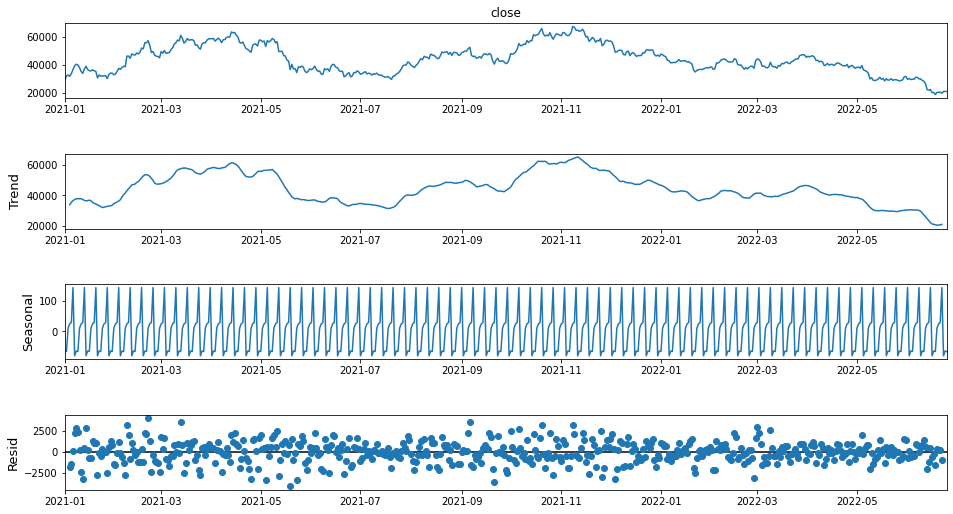

In [7]:
fig_path = c.FIG_FLD / 'crypto_analysis/seasonal_decomposer.jpg'
analy.plot_seasonal_decomposer(y='close', saving_figloc=fig_path, all_inches=(15, 8))

## Temporal Estability

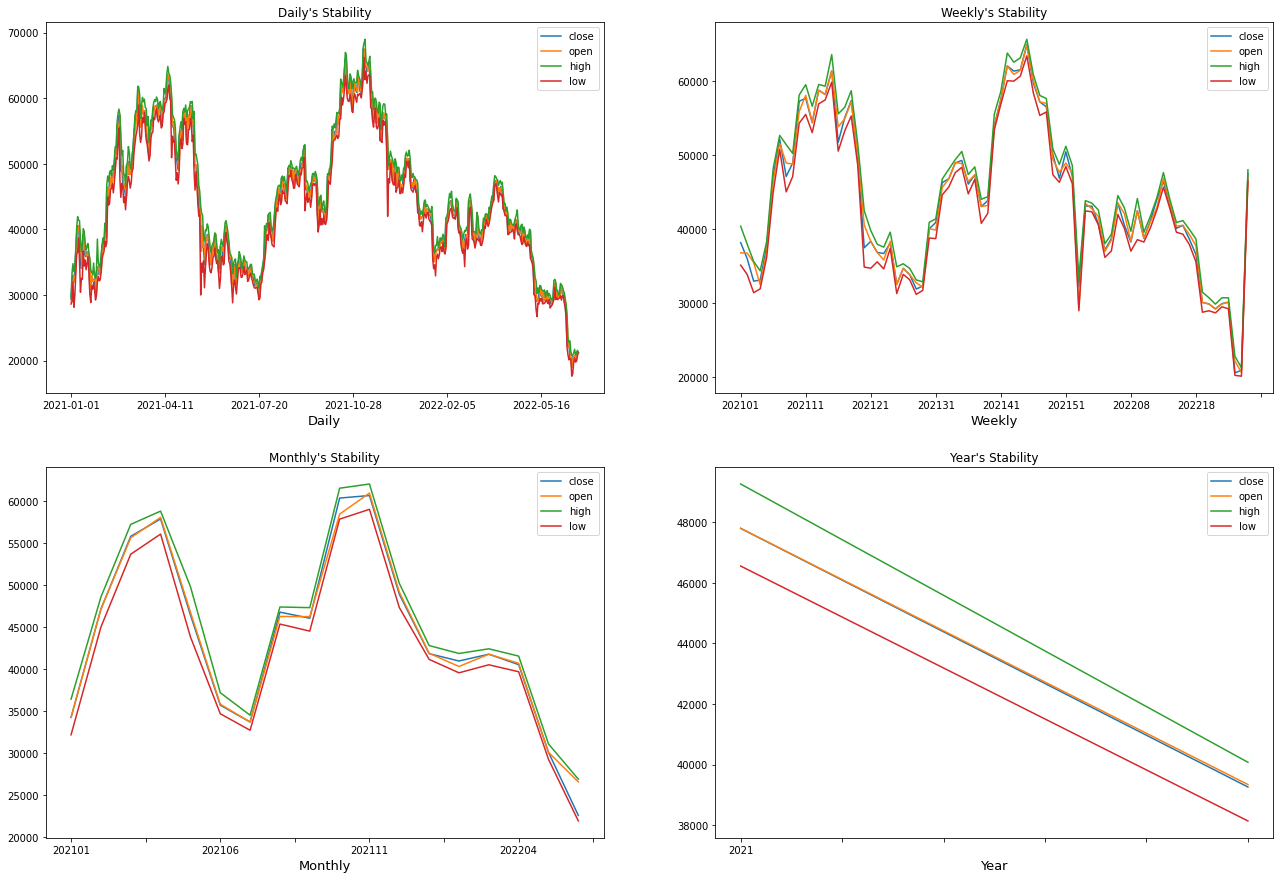

In [8]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_stability_all.jpg'
analy.all_timely_stability(y=['close', 'open', 'high', 'low'], saving_figloc=fig_path)

## Outlier Identification

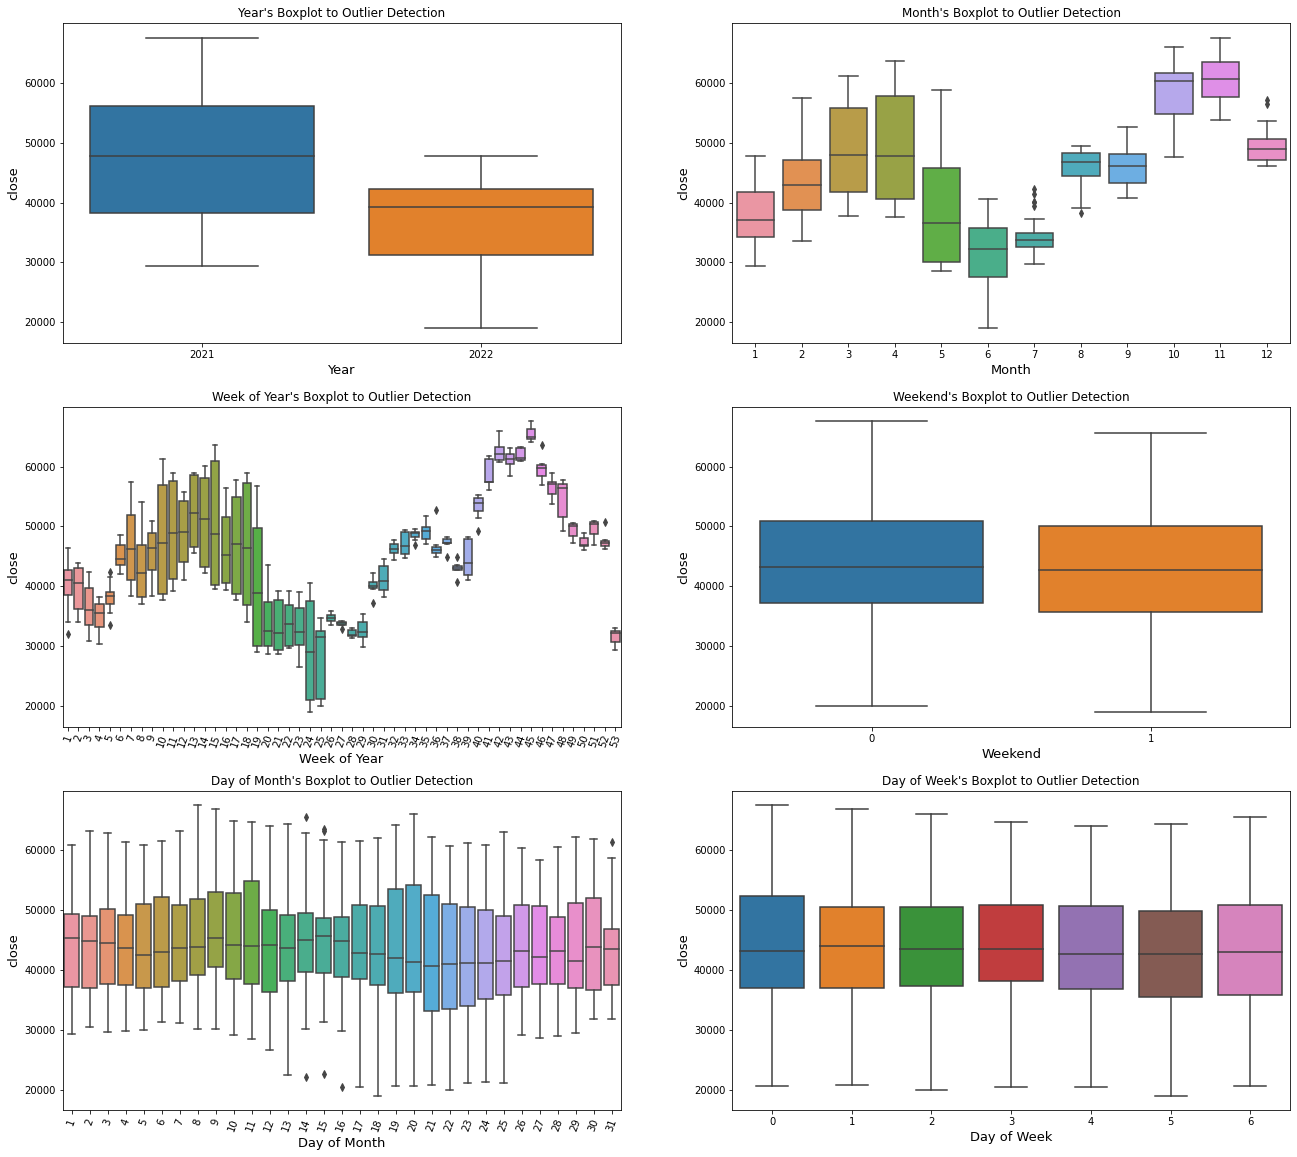

In [9]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_outlier_detector_all.jpg'
analy.all_temporal_outlier_detector_boxplots(y='close', saving_figloc=fig_path)

## Distribution

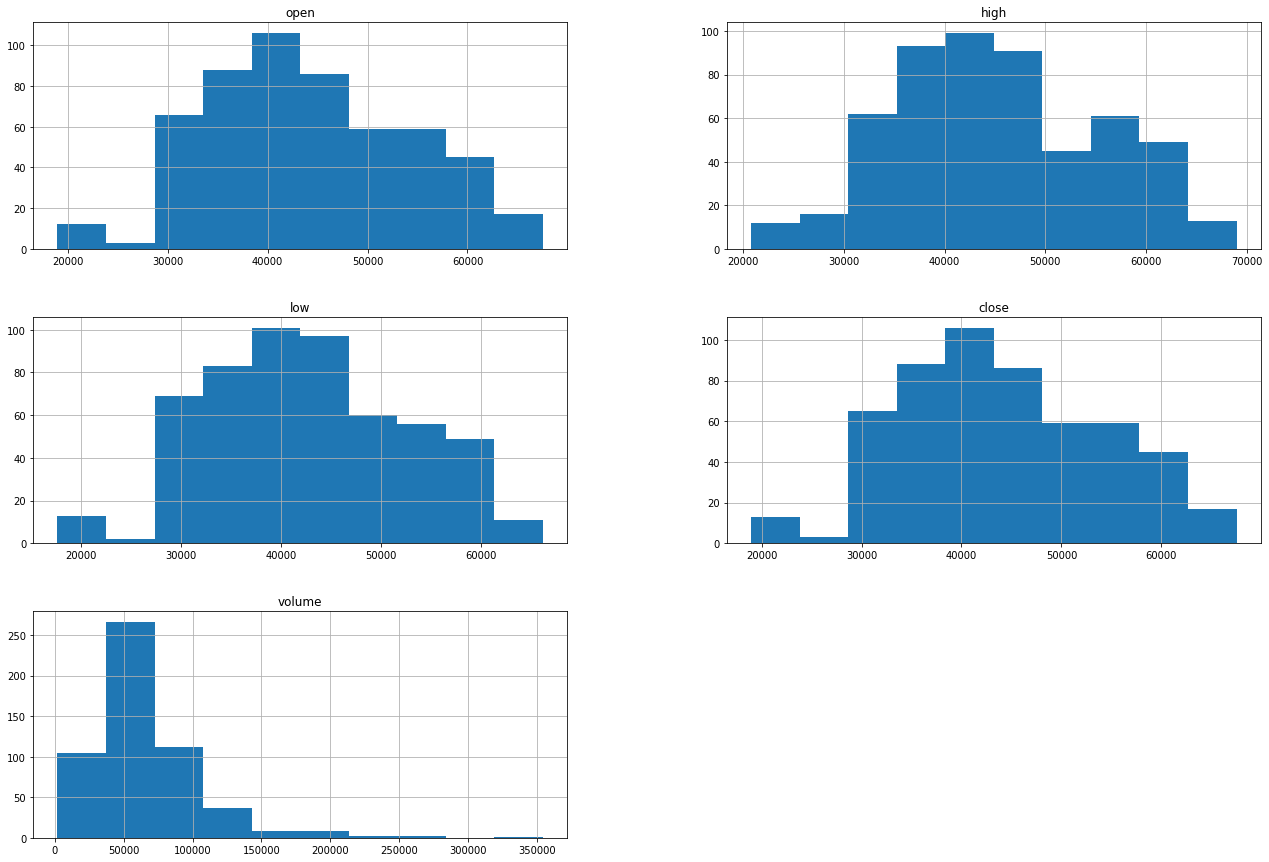

In [10]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_distribution_check.jpg'
analy.distribution_check(saving_figloc=fig_path)

## Nature Transformation Effect

DataAnaly || 2022-06-25 12:35:14,129 (WARNING) || The mean difference in log1p transformation 
                                         is below 0.01! (difference = 3.362272464964615e-14)
DataAnaly || 2022-06-25 12:35:14,168 (WARNING) || The mean difference in yeo-johnson transformation 
                                         is below 0.01! (difference = 6.818688558948238e-12)


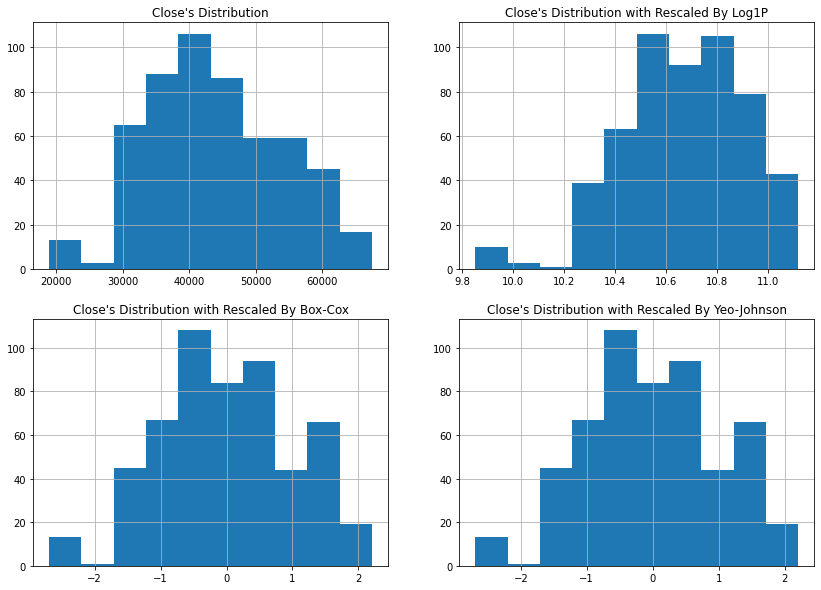

In [11]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_nature_transformation_check.jpg'
analy.rescalling_effect_check(y='close', all_figsize=(14, 10), saving_figloc=fig_path)

# 3.0. Data Preparation

In [12]:
transforming_df = DataTransform(df=df_btc_usd, date_col='timestamp', individual_figsize=(18, 8), start_date='2021-01-01')
df1, scaler = transforming_df.prepare_dataframe_timeseries(y='open', method='log1p')

DataTrans || 2022-06-25 12:35:14,667 (WARNING) || The mean difference in log1p transformation 
                                         is below 0.01! (difference = 2.084608928278061e-13)


# 4.0. Machine Learning Model

## 4.1. SARIMAX

### 4.1.1. Modeling

### 4.1.2. Validation

## 4.2. ARIMA

### 4.2.1. Modeling

In [13]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [14]:
df2['rolling_mean_diff'].dropna()

NameError: name 'df2' is not defined

In [ ]:
dftest = adfuller(df2['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.591144016431777
2. P-Value :  0.005932609762980111
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 511
5. Critical Values :
	 1% :  -3.4432119442564324
	 5% :  -2.8672126791646955
	 10% :  -2.569791324979607


In [ ]:
df2 = pd.DataFrame(df1)

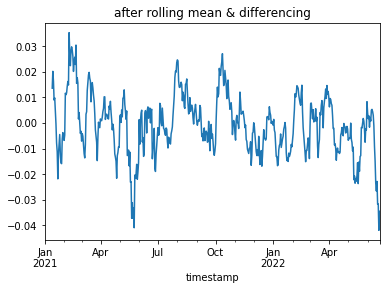

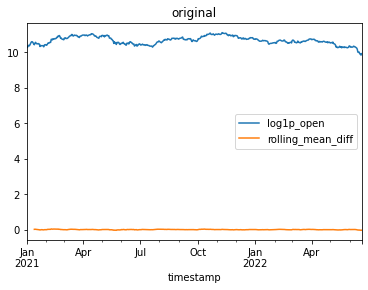

In [ ]:
rolling_mean = df2['log1p_open'].rolling(window = 12).mean()
df2['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
df2['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
df2.plot(title='original');

### 4.2.2. Validation

## 4.3. Saving Model